# Espacio de Color CIE-1931

## Materia - Visualización de la Información, UNAM, Licenciatura en Ciencia de Datos

## En este notebook se explicará la herramienta de nuestra autoría, ColorVisualizer. Esta proporciona diversas formas de visualizar espacios de color (especialmente el CIE-1931).

## Integrantes:
### Mario Garrido
### Alejandro Hernández
### Armando Ríos

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
%matplotlib notebook
import colour
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Cursor
from matplotlib.colors import rgb2hex
from scipy.interpolate import interp1d
import warnings; warnings.filterwarnings('ignore')
import numpy as np; np.random.seed(1)

### Herramienta: ColorVisualiazer

Esta provee de funcionalidades para poder visualizar una proyección del espacio CIE 1931, longitudes de onda de color, mapas cúbicos de color, y la localización de un cierto color dentro del espacio de color.

In [5]:
class ColorVisualizer:
    """
    Clase que engloba a la herramienta de visualización de Color para CIE 1931.
    
    Todos los métodos son estáticos, por lo que no hay necesidad de instanciarla.
    """
    @staticmethod
    def plot_CIE_1931():
        """
        Devuelve un plot del diagrama de cromacidad CIE1931
        
        return: fig, ax (objetos de plot de matplotlib)
        """
        return colour.plotting.plot_chromaticity_diagram_CIE1931()
    @staticmethod
    def plot_CIE_1931_sRGB():
        """
        Devuelve un plot del diagrama de cromacidad CIE1931 con el espacio sRGB sobreimpuesto.
        
        return: fig, ax (objetos de plot de matplotlib)
        """
        return colour.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(['sRGB'])
    @staticmethod
    def sRGB_plot_color(rgb, show_sRGB_space=True):
        """
        Devuelve un plot del diagrama de cromacidad CIE1931 y la ubicación de un
        color en sRGB que se le pase, el cual estará indicado en su posición en la gráfica.
        
        args:    rgb - arreglo de tres elementos con los valores r, g y b en escala (0,1).
                 show_sRGB_space = True - Booleano que indica si generar o no el espacio sRGB sobreimpuesto.
            
        return: fig, ax (objetos de plot de matplotlib)
        """
        return ColorVisualizer.CIE_1931_plot_color(colour.sRGB_to_XYZ(rgb), show_sRGB_space)
    @staticmethod
    def CIE_1931_plot_color(color, show_sRGB_space = False):
        """
        Devuelve un plot del diagrama de cromacidad CIE1931, asimismo el color en 
        XYZ que se le pase estará indicado en su posición en la gráfica.
        
        args:    color - arreglo de tres elementos con los valores X, Y y Z  (CIE 1931)
                 show_sRGB_space = False - Booleano que indica si generar o no el espacio sRGB sobreimpuesto.
            
        return: fig, ax (objetos de plot de matplotlib)
        """
        coordenadas = colour.XYZ_to_xy(color)
        if show_sRGB_space:
            fig, ax = colour.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(['sRGB'])
            ax.annotate('  ', xy=(coordenadas[0], coordenadas[1]),  xycoords='data',
                 xytext=(-30, 0), textcoords='offset points',
                 size=13, ha='right', va="center",
                 bbox=dict(boxstyle="round", alpha=1, facecolor = mcol.to_rgba(colour.XYZ_to_sRGB(color)), edgecolor='black'),
                 arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2"))
            return fig, ax
        else:
            fig, ax = colour.plotting.plot_chromaticity_diagram_CIE1931()
            ax.annotate('  ', xy=(coordenadas[0], coordenadas[1]),  xycoords='data',
                 xytext=(-30, 0), textcoords='offset points',
                 size=13, ha='right', va="center",
                 bbox=dict(boxstyle="round", alpha=1, facecolor = mcol.to_rgba(colour.XYZ_to_sRGB(color)), edgecolor='black'),
                 arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2"))
            return fig, ax
    @staticmethod
    # Crea un arreglo de indices de 3 dimensiones
    def creacion_cubos(n):
        """
        Devuelve un arreglo booleano de 3 dimensiones que indica si el cubo en la ubicación (i,j,k) 
        sera ploteado o no, además retorna un arreglo de 1 dimensión conteniendo el color para cada cubo.
        
        args:    n - Es la dimensión de cada 
                 show_sRGB_space = True - Booleano que indica si generar o no el espacio sRGB sobreimpuesto.
            
        return: voxels, colors
        """
        x, y, z = np.indices((n, n, n))

        cubes = []
        colores = []
        # Para crear cada cubo, se define un arreglo booleano de la dimension del espacion donde la posicion del cubo es True
        # Y las demas son false
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    cubes.append(((i <= x) & (x < (i+1))) & ((j <= y) & (y < (j+1))) & ((k <= z) & (z < (k+1))))
                    # Los colores los represento con HEX
                    colores.append(rgb2hex([1 - i/n,1 - j/n, 1 - k/n]))

        # Ahora creamos un arreglo booleano Voxels que define que todos los cubos se imprimiran
        voxels = cubes[0]
        for cube in cubes:
            voxels |= cube

        # Ahora a cada cubo le asignamos un color
        colors = np.empty(voxels.shape, dtype=object)
        for cube,color in zip(cubes,colores):
            colors[cube] = color

        return voxels, colors
    @staticmethod
    def plot_color_map(n, transparencia):
        """
        Devuelve un plot del mapa de color de cubos dividio en n^3 cubos y una transparencia dada.
        
        args:    n - Número de cubos que tendrá el mapa de color por arista.
                 transparencia - Transparencia de los cubos en el mapa en rango (0,1)
            
        return: fig, ax (objetos de plot de matplotlib)
        """
        voxels, colors = ColorVisualizer.creacion_cubos(n)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_title("Mapa de color RGB con {} cubos".format(n**3))
        ax.set_xlabel('BLUE')
        ax.set_ylabel('RED')
        ax.set_zlabel('GREEN')

        ax.voxels(voxels, facecolors=colors, edgecolor='k', alpha = transparencia)
        return fig, ax
    @staticmethod
    def color_matching_cie(data):
        """
        Devuelve un plot del espectro de los datos pasados en amplitud de onda RGB.
        
        args:    data - Arreglo bidimensional de datos.
            
        return: fig, axs (objetos de plot de matplotlib)
        """
        # Datos del articulo CIE
        fig, axs = plt.subplots(2, figsize=(10, 7))
        f1 = interp1d(data[0,:], data[1,:], kind='cubic')
        f2 = interp1d(data[0,:], data[2,:], kind='cubic')
        f3 = interp1d(data[0,:], data[3,:], kind='cubic')

        spectro = np.linspace(380, 780, 100)
        axs[0].set_title("Color matching functions for RGB")
        axs[0].set_ylabel('Luminosidad')
        axs[0].set_xlabel('Wavelength [nm]')
        axs[0].plot(spectro, f1(spectro), color = 'red')
        axs[0].plot(spectro, f2(spectro), color = 'green')
        axs[0].plot(spectro, f3(spectro), color = 'blue')
        axs[0].legend(["$\hat{r}(\lambda)$", "$\hat{g}(\lambda)$", "$\hat{b}(\lambda)$"])
        axs[0].set_xlim(390, 700)
        axs[0].grid()

        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=390, vmax=700)

        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=axs[1], orientation='horizontal', label='Wavelength [nm]')

        return fig,axs


Aquí podemos notar un mapa de cubos para el espacio de color. Esto nos permite discretizar el espacio de color RGB en una cantidad ajustable de niveles.

<IPython.core.display.Javascript object>


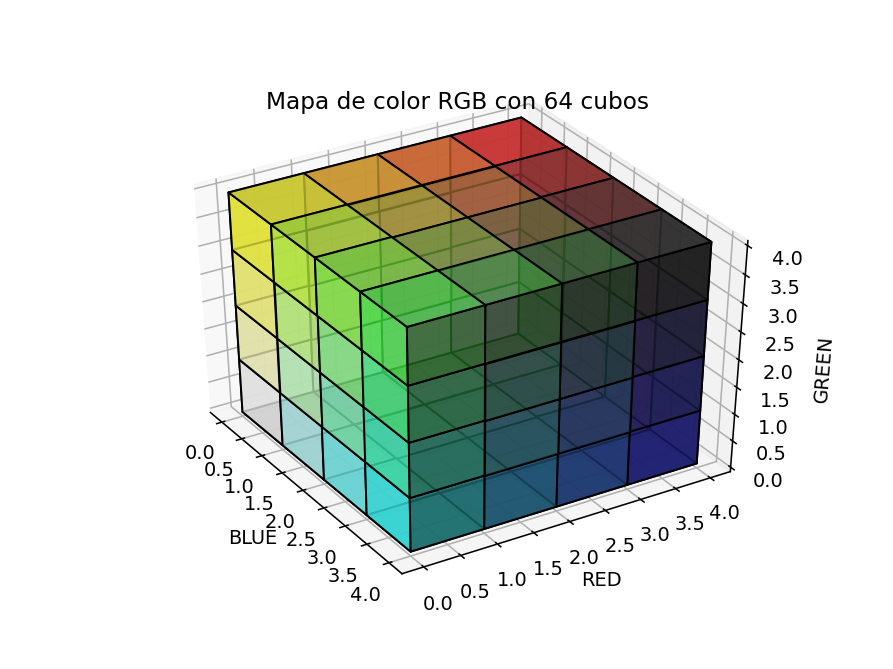

In [7]:
ColorVisualizer.plot_color_map(4, 0.8)
plt.show()

También podemos visualizar las ondas de color rojo, verde y azul para algún color.

Abajo se pueden mostrar para todo el espectro.

In [8]:
# Datos de longitud de onda registrados por la CIE
data = np.array([[380 ,400 ,420 ,440 ,460 ,480 ,500 ,520 ,540 ,560 ,580 ,600 ,620 ,640 ,660 ,680 ,700 ,720 ,740 ,760 ,780], 
                 [0.00003, 0.0003, 0.00211, -0.00261, -0.02608, -0.04939, -0.07173, -0.09264, -0.03152, 0.0906, 0.24526, 0.34429, 0.29708, 0.15968, 0.05932, 0.01687, 0.0041, 0.00105, 0.00025, 0.00006, 0], 
                 [-0.00001, -0.00014, -0.0011, 0.00149, 0.01485, 0.03914, 0.08536, 0.17468, 0.21466, 0.19702, 0.1361, 0.06246, 0.01828, 0.00334, 0.00037, 0.00003, 0, 0, 0, 0, 0], 
                 [0.00117, 0.01214, 0.11541, 0.31228, 0.29821, 0.14494, 0.04776, 0.01221, 0.00146, -0.0013, -0.00108, -0.00049, -0.00015, -0.00003, 0, 0, 0, 0, 0, 0, 0]])


<IPython.core.display.Javascript object>


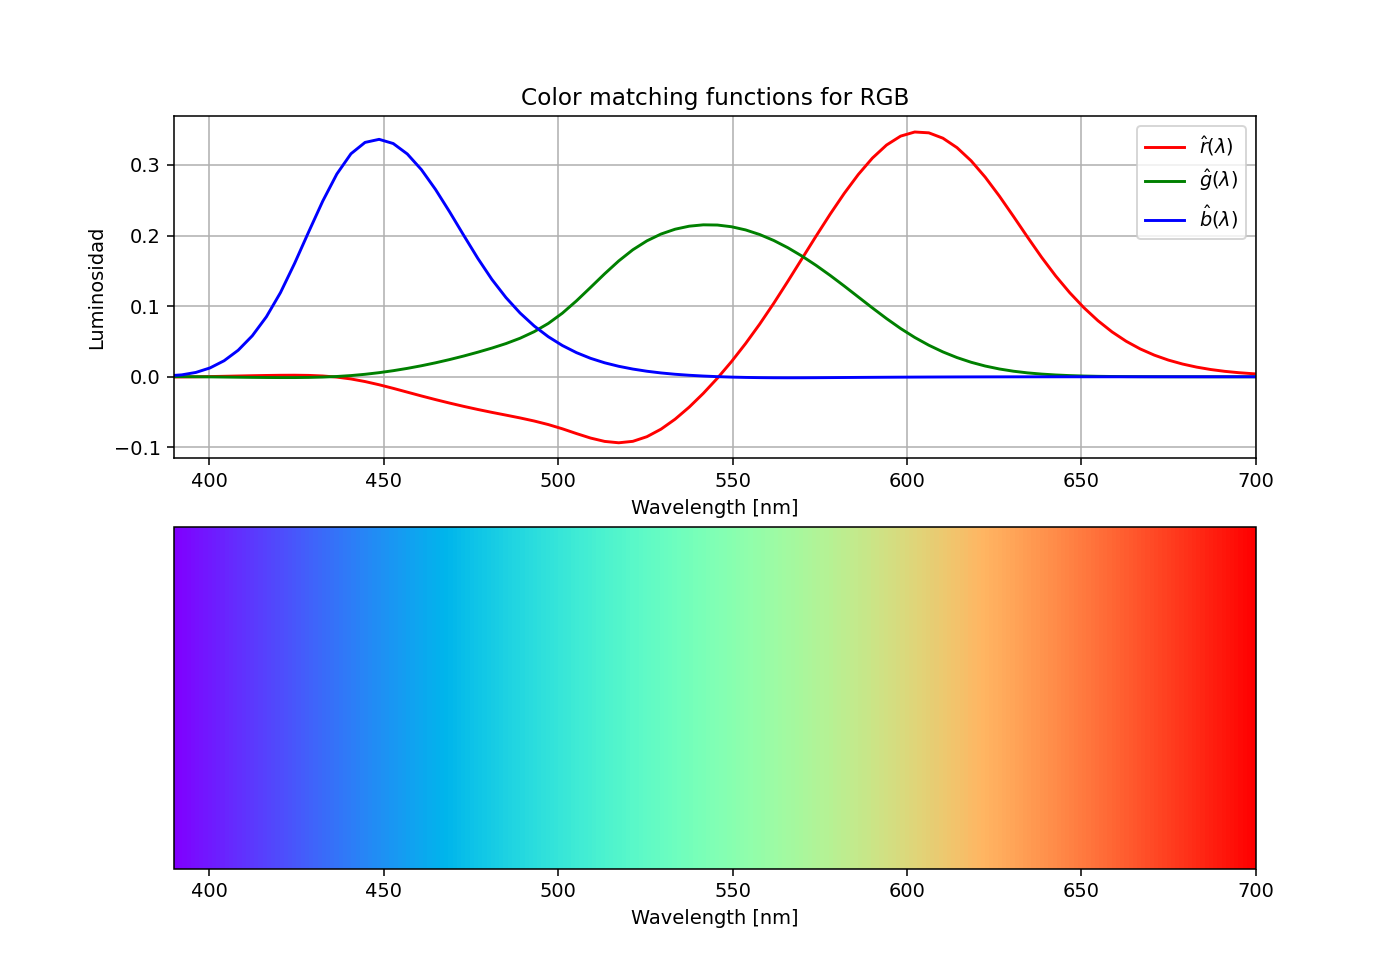

In [9]:
ColorVisualizer.color_matching_cie(data)
plt.show()

### Definición del diagrama de cromaticidad

En el caso anterior color matching es correcto si suponemos que la luminosidad de la luz azul es igual a la de la vere y roja. Entonces para normalizar la luminocidad, tenemos que cambiar la escala de cada color, dividiendolo entre su luminosidad.

$$L_r = 1$$
$$L_g = 4.5907$$ 
$$L_b = 0.0601$$
$$\hat{r}(\lambda) = R = \frac{r(\lambda)}{L_r}$$
$$\hat{g}(\lambda) = G = \frac{g(\lambda)}{L_g}$$
$$\hat{b}(\lambda) = B = \frac{b(\lambda)}{L_b}$$

A estos valores R,G,B se les llama en ingles "Tristimulus values".

Una vez obtenidos los valores de triestimulares, es fácil obsevar que para generar cierta gama de colores es necesario tener un rojo "negativo", eso complica la representación de colores. Y además no es facil imaginar la representación de colores en un espacio $3D$ sería más sencillo mapearlo a un espacio 2D. Para eso es la cromaticidad. Primero debemos obtener las coordenadas en el espacio cromático.

$$r = \frac{R}{(R+G+B)}$$ 
$$g = \frac{G}{(R+G+B)}$$
$$b = \frac{B}{(R+G+B)}$$

Esta nueva representación $r + g + b = 1$ normalizada significa ahora que tanto color necesitamos de cada compomente del 0 al 1.

In [10]:
lambdaf = data[0,:]
# Normalización de los datos para obtener r + g + b = 1
r = data[1,:] / (data[1,:] + data[2,:] + data[3,:]) 
g = data[2,:] / (data[1,:] + data[2,:] + data[3,:]) 
b = data[3,:] / (data[1,:] + data[2,:] + data[3,:]) 


### Curva de cromaticidad

Una vez normalizados los datos, podemos representar la región los colores del espectro visible con una curva en el espacion (r,g,b)

In [11]:
# Dado que los datos son pocos, utilizamos una interpolación cúbica para suavizar la gráfica
f1 = interp1d(lambdaf[:-1], r[:-1], kind='cubic')
f2 = interp1d(lambdaf[:-1], g[:-1], kind='cubic')
f3 = interp1d(lambdaf[:-1], b[:-1], kind='cubic')
    
espectro = np.linspace(380, 760, 100)

r_i = f1(espectro)
g_i = f2(espectro)
b_i = f3(espectro)

<IPython.core.display.Javascript object>


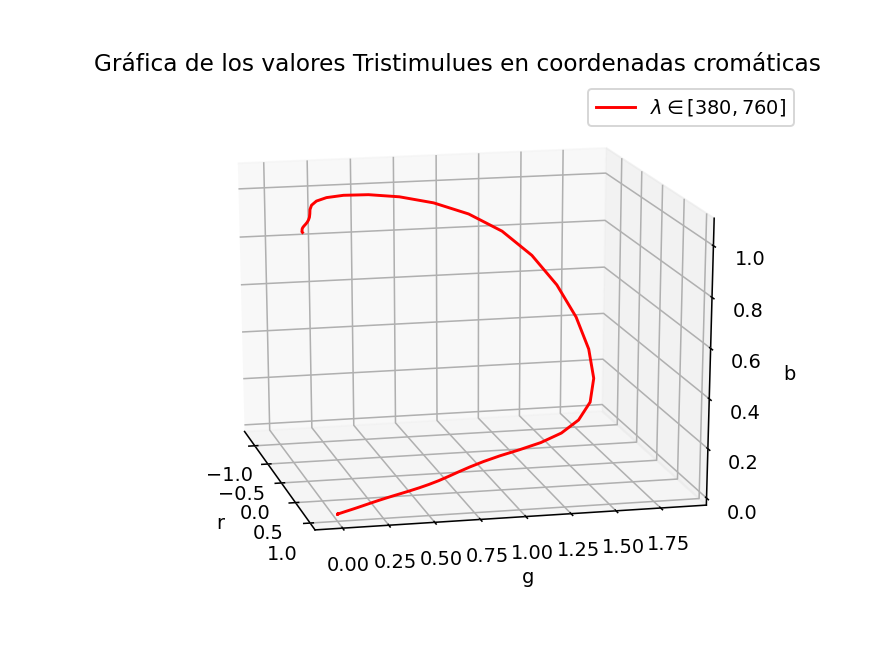

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("Gráfica de los valores Tristimulues en coordenadas cromáticas", y = 1.08)
ax.plot(r_i, g_i, b_i, color = 'red')
ax.legend(["$\lambda \in [380, 760]$"])
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
plt.show()

### Proyección a un plano
Ahora cómo sabemos que $r + g + b = 1$ $b$ depende de $r$ y $g$ cómo $b = 1 - r - g$, entonces podemos quedarnos unicamente con la gráfica en 2D de $r$ y $g$ por fines de comodidad.

<IPython.core.display.Javascript object>


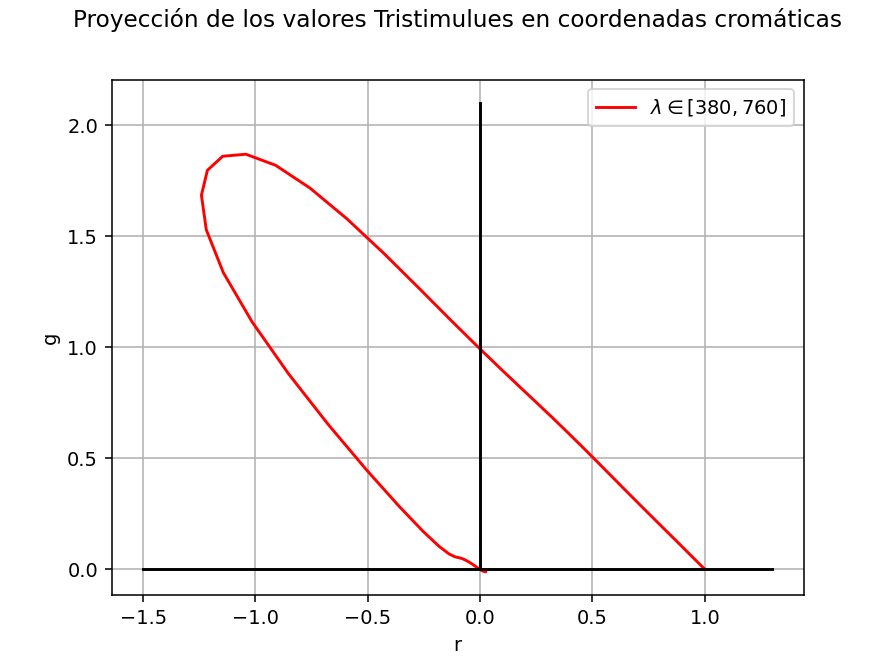

In [13]:
r_i = f1(espectro)
g_i = f2(espectro)
b_i = f3(espectro)

fig = plt.figure()
plt.title("Proyección de los valores Tristimulues en coordenadas cromáticas", y = 1.08)
plt.plot(r_i, g_i, color = 'red')
plt.plot([0, 0],[0.0, 2.1],color = 'black')
plt.plot([-1.5, 1.3],[0, 0],color = 'black')
plt.legend(["$\lambda \in [380, 760]$"])
plt.xlabel('r')
plt.ylabel('g')
plt.grid()
plt.show()

Para que este en valores entre 0 y 1, se puede aplicar una transformación lineal y por fin obtendremos los valores X, Y, Z de la CIE.

\begin{equation*}
\begin{pmatrix}
 X\\
 Y\\
 Z
\end{pmatrix} = T_{3,3}
\begin{pmatrix}
R\\
G \\
B
\end{pmatrix}
\end{equation*}

En un artículo proveen la transformación T en la parte de abajo.

\begin{equation*}
T =
\begin{pmatrix}
2.768 & 1.751 & 1.130\\
1.000 & 4.590 & 0.060 \\
0 & 0.056 & 5.594
\end{pmatrix}
\end{equation*}

Pero dado que los datos con los que contamos son pocos y además interpolamos cubicamente, al transformar la región de cromaticidad no esta en el subespacio $[0, 1]x[0, 1]$ de $R^2$ 

<IPython.core.display.Javascript object>


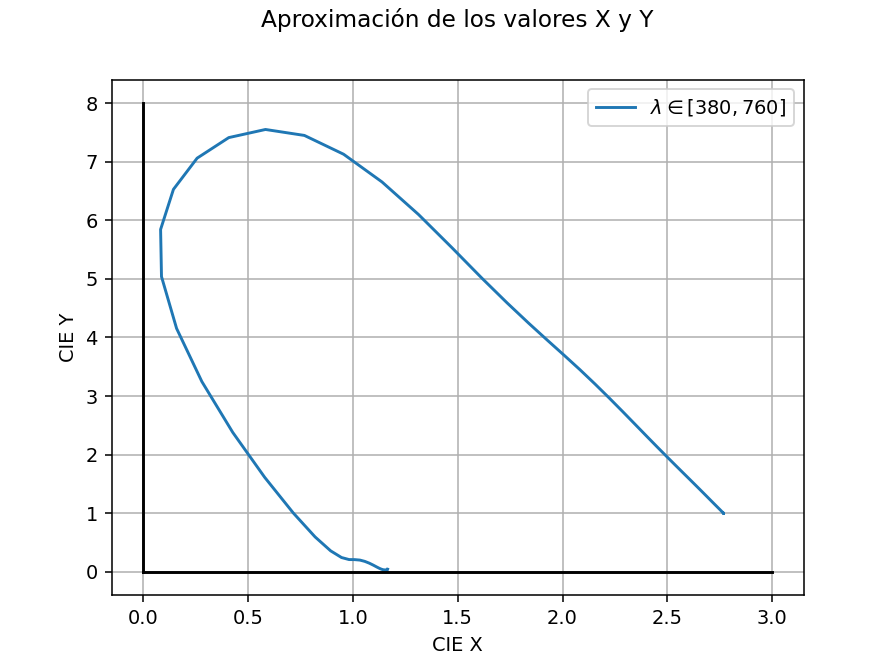

In [14]:
fig = plt.figure()
Tran = np.array([[2.768,1.751,1.130], [1.000,4.590,0.060], [0,0.056,5.594]])
data_i = np.array([r_i, g_i, b_i])
XYZ = Tran@data_i
plt.title("Aproximación de los valores X y Y", y = 1.08)
plt.plot(XYZ[0,:], XYZ[1,:])
plt.plot([0, 0],[0.0, 8],color = 'black')
plt.plot([0.0, 3],[0, 0],color = 'black')
plt.legend(["$\lambda \in [380, 760]$"])
plt.xlabel('CIE X')
plt.ylabel('CIE Y')
plt.grid()
plt.show()

Entonces un truco para aproximar los datos sería normalizar los datos despues de la transformación, que nos da una idea de la forma en la que se ve el diagrama de cromaticidad. De igual manera en la parte de abajo se utiliza un modulo de python donde ya esta bien implementado. Estás gráficas son para fines educativos.

<IPython.core.display.Javascript object>


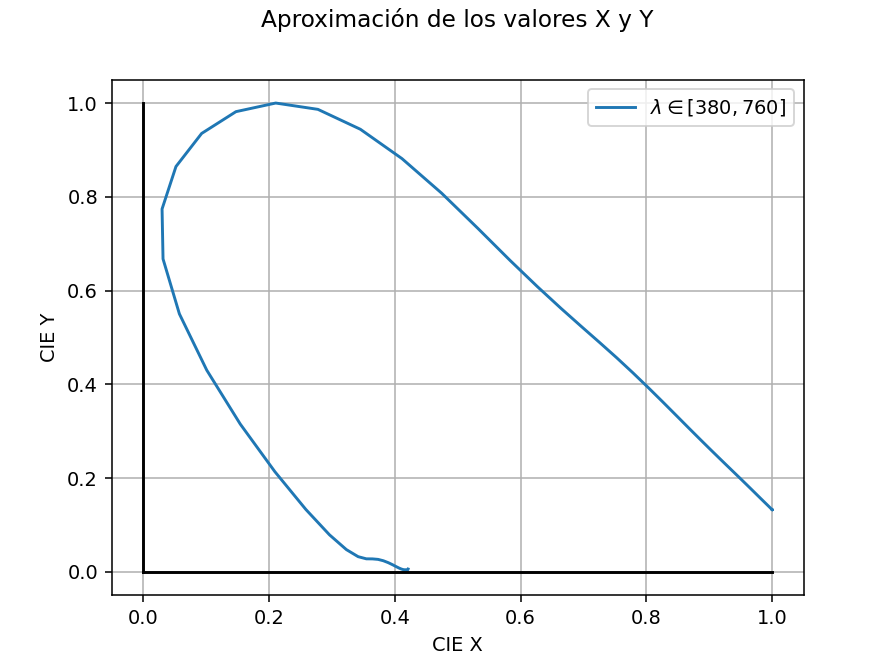

In [15]:
fig = plt.figure()
Tran = np.array([[2.768,1.751,1.130], [1.000,4.590,0.060], [0,0.056,5.594]])
data_i = np.array([r_i, g_i, b_i])
XYZ = Tran@data_i
plt.title("Aproximación de los valores X y Y", y = 1.08)
plt.plot(XYZ[0,:]/np.max(XYZ[0,:]), XYZ[1,:]/np.max(XYZ[1,:]))
plt.plot([0, 0],[0.0, 1],color = 'black')
plt.plot([0.0, 1],[0, 0],color = 'black')
plt.legend(["$\lambda \in [380, 760]$"])
plt.xlabel('CIE X')
plt.ylabel('CIE Y')
plt.grid()
plt.show()

## Visualizando colores en el diagrama de cromacidad CIE 1931.

Podemos hacer visualizaciones de distintas maneras.

En el siguiente caso vamos a visualizar un color rosa (en sRGB) dentro del diagrama de cromacidad, y viendo donde cae en relación con el mismo espacio sRGB.

In [16]:
ColorVisualizer.sRGB_plot_color([0.93,0.0,0.9], True)
plt.show()

AttributeError: module 'colour' has no attribute 'sRGB_to_XYZ'

Podemos hacer lo mismo que antes, pero sin mostrar el espacio sRGB.

In [17]:
ColorVisualizer.sRGB_plot_color([0.93,0.0,0.9], False)
plt.show()

AttributeError: module 'colour' has no attribute 'sRGB_to_XYZ'

Para solo visualizar el diagrama de cromacidad, podemos llamar esta función.

In [18]:
ColorVisualizer.plot_CIE_1931()
plt.show()

AttributeError: module 'colour' has no attribute 'plotting'

Y para visualizar el espacio sRGB dentro del diagrama de cromacidad CIE 1931, podemos llamar:

In [19]:
ColorVisualizer.plot_CIE_1931_sRGB()
plt.show()

AttributeError: module 'colour' has no attribute 'plotting'